In [1]:
#ViT
import numpy as np
import pandas as pd
from memory_profiler import memory_usage

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split
#from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from PIL import Image, ImageOps
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')


#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
num_workers = 0
script = False

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data, train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


In [6]:
model = ViTBase16(n_classes=7, pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

name = 'Experiments/exp_53/model.pt'#'model.pt'#'other.pt' 
model = torch.load(name, map_location=torch.device('cpu'))

In [7]:
# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/Jacobs_Y6/Cutouts/Jacobs_Y6.fits'
hdu_list = fits.open(path_cutouts)
lenses = hdu_list[1].data 
data_pos = hdu_list[2].data
data_pos = Table(data_pos)
data_pos = data_pos.to_pandas()
hdu_list.close()

# Negative cases
path_neg = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/vit_cnn/Data/negative_redmagic.fits'
hdu_list = fits.open(path_neg)
ind = random.sample(range(len(hdu_list[1].data)), 2)
negatives = hdu_list[1].data[ind,:] 
negatives = negatives[:,0:3,:,:]
columns_data = data_pos.columns
data_neg = pd.DataFrame(columns=columns_data)
my_list = [0]*len(negatives)
for column in columns_data:
    data_neg[column] = my_list
hdu_list.close()

images = np.concatenate((lenses, negatives)).astype(np.float32)
data = pd.concat((data_pos, data_neg))
labels_lenses, labels_negatives = np.zeros(len(lenses), dtype = np.int64), np.ones(len(negatives), dtype = np.int64)
labels = np.concatenate((labels_lenses, labels_negatives))

train_dataset, test_dataset = make_train_test_datasets(images, data, labels, test_size=0.99, transform=transform)
print(len(train_dataset), len(test_dataset))
print(sum(test_dataset.labels==0))
print(sum(test_dataset.labels==1))

4 494
492
2


In [8]:
print(data_pos.columns)

Index(['COADD_OBJECT_ID', 'TILENAME', 'HPIX_16384', 'HPIX_4096',
       'DNF_ZMEAN_SOF', 'RA', 'DEC', 'grade', 'photoz', 'imag',
       'FLUX_RADIUS_G', 'FLUX_RADIUS_R', 'FLUX_RADIUS_I', 'FLUX_RADIUS_Z',
       'KRON_RADIUS', 'GAP_FLUX_G', 'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G',
       'SOF_BDF_FLUX_G', 'SOF_PSF_FLUX_G', 'MAG_AUTO_G', 'MAG_APER_4_G',
       'MAG_APER_8_G', 'SOF_BDF_G_1', 'SOF_BDF_G_2', 'IMAFLAGS_ISO_G',
       'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I', 'IMAFLAGS_ISO_Z', 'Candidate',
       'objectid'],
      dtype='object')


In [9]:
search_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, num_workers=num_workers, shuffle=True)
prob_lim = 0.5

In [10]:
right_positives, wrong_positives = np.zeros((1, 3, 45, 45)), np.zeros((1, 3, 45, 45))
right_negatives, wrong_negatives = np.zeros((1, 3, 45, 45)), np.zeros((1, 3, 45, 45))
right_data, wrong_data = pd.DataFrame(columns=columns_data), pd.DataFrame(columns=columns_data)
prob_list = []
for i_batch, sample in enumerate(tqdm(search_loader)):
    #if(i_batch==80): break
    
    sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'], sample['img'], sample['data']
        
    output = model(sample_image)
    predicted = output.argmax(dim=1).item()
    
    prob = nn.Softmax(dim=1)(output)
    prob = prob[:,0].detach().numpy()[0]
    prob_list.append(prob)
    
    predicted = 0 if prob >= prob_lim else 1
    
    if(predicted == 0 and sample_label.item() == 0):
        right_positives = np.append(right_positives, [np.array(sample_img[0])], axis = 0)
        sample_data['Prob'] = prob
        data_point = pd.DataFrame.from_dict(sample_data)
        right_data = right_data.append(data_point)
    elif(predicted != 0 and sample_label.item() == 0):
        wrong_positives = np.append(wrong_positives, [np.array(sample_img[0])], axis = 0)
        sample_data['Prob'] = prob
        data_point = pd.DataFrame.from_dict(sample_data)
        wrong_data = wrong_data.append(data_point)
    elif(predicted == 1 and sample_label.item() == 1):
        right_negatives = np.append(right_negatives, [np.array(sample_img[0])], axis = 0)
    elif(predicted == 0 and sample_label.item() == 1):
        wrong_negatives = np.append(wrong_negatives, [np.array(sample_img[0])], axis = 0)

right_positives = np.delete(right_positives, 0, axis = 0)
wrong_positives = np.delete(wrong_positives, 0, axis = 0)
right_negatives = np.delete(right_negatives, 0, axis = 0)
wrong_negatives = np.delete(wrong_negatives, 0, axis = 0)

  0%|          | 0/494 [00:00<?, ?it/s]

In [11]:
#Threshold of probability: 0.5
print('Total: ' + str(len(wrong_positives) + len(right_positives)))
print('Identified: ' + str(len(right_positives)))
print('Not identified: ' + str(len(wrong_positives)))
print(' ')

ind = right_data[right_data['Prob'] > 0.949].index
print('Right positives with a 0.949 threshold: '+ str(len(ind)))
ind = right_data[right_data['Prob'] > 0.974].index
print('Right positives with a 0.974 threshold: '+ str(len(ind)))

Total: 492
Identified: 424
Not identified: 68
 
Right positives with a 0.949 threshold: 372
Right positives with a 0.974 threshold: 356


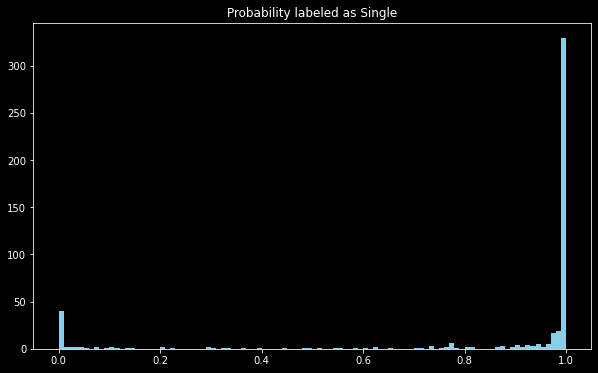

In [12]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob_list, 100, color = "skyblue")
plt.show()

In [13]:
def make_plot_all(objects, data):
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                #title = 'Mag: {:.2f}, z: {:.2f}'.format(data['MAG_APER_4_G'].values[i+j], data['DNF_ZMEAN_SOF'].values[i+j])
                title = '{:.3f}'.format(data['Prob'].values[i+j])
                print(data['COADD_OBJECT_ID'].values[i+j])
                plt.title(title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

In [14]:
wrong_data.columns

Index(['COADD_OBJECT_ID', 'TILENAME', 'HPIX_16384', 'HPIX_4096',
       'DNF_ZMEAN_SOF', 'RA', 'DEC', 'grade', 'photoz', 'imag',
       'FLUX_RADIUS_G', 'FLUX_RADIUS_R', 'FLUX_RADIUS_I', 'FLUX_RADIUS_Z',
       'KRON_RADIUS', 'GAP_FLUX_G', 'MOF_BDF_FLUX_G', 'MOF_PSF_FLUX_G',
       'SOF_BDF_FLUX_G', 'SOF_PSF_FLUX_G', 'MAG_AUTO_G', 'MAG_APER_4_G',
       'MAG_APER_8_G', 'SOF_BDF_G_1', 'SOF_BDF_G_2', 'IMAFLAGS_ISO_G',
       'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_I', 'IMAFLAGS_ISO_Z', 'Candidate',
       'objectid', 'Prob'],
      dtype='object')

Wrong lenses
68
68
1532721542
977331342
1333189566
1205139711


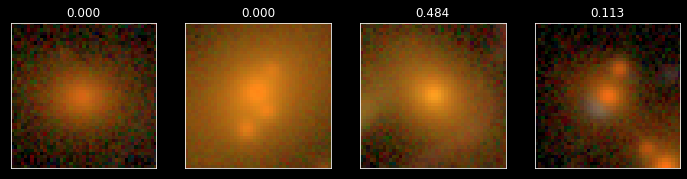

1231169165
1448395045
1378074900
1403056859


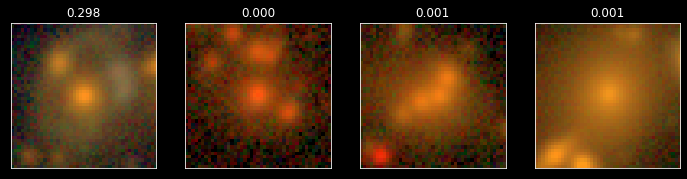

987073198
1051491894
1200499492
1159009987


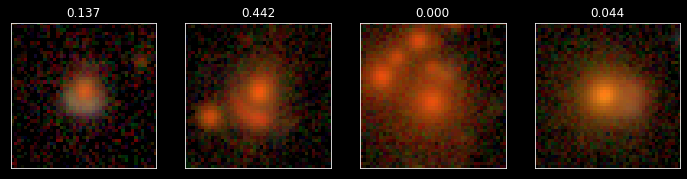

952827527
1486397038
1365603963
1162461053


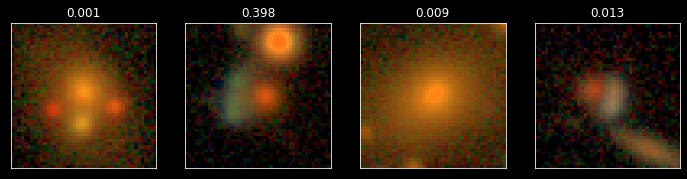

1417005344
1504184978
1518678765
1279191353


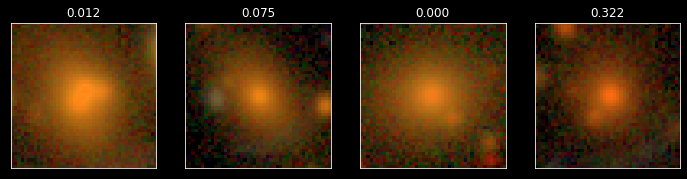

992158653
1098354338
1386329475
943699147


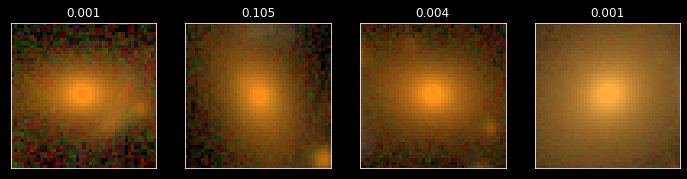

1320102858
1389753930
933728043
1371066768


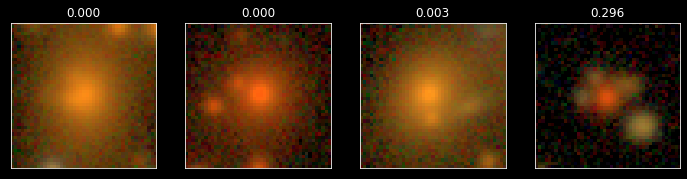

1576743294
931716591
1478719341
1210817563


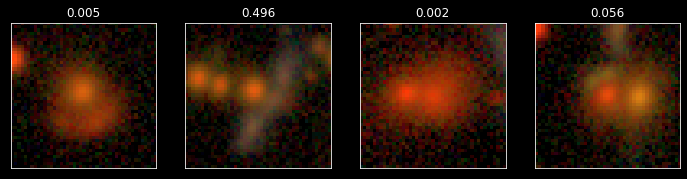

1394900142
1544354650
1204581428
1614852030


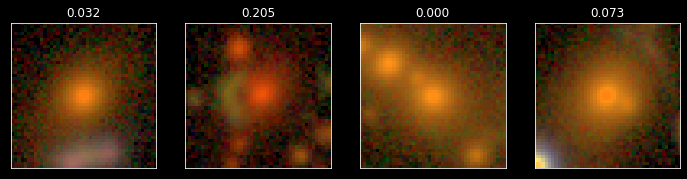

1342368789
1333534239
955120453
1144014836


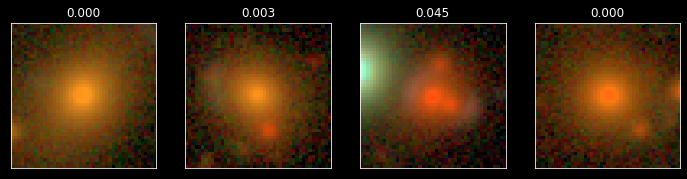

1005190830
1553993296
1269458842
1369627471


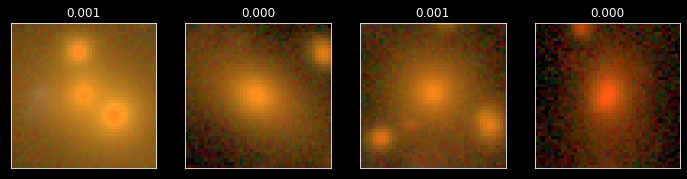

992157466
1399379493
1454422743
1345137000


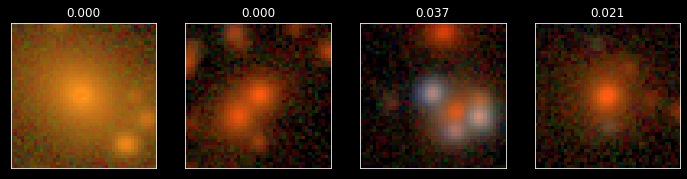

1372004130
1420520224
1051762909
925978772


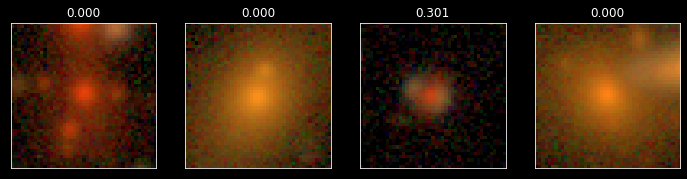

1027060361
1403871221
1387236198
1293358551


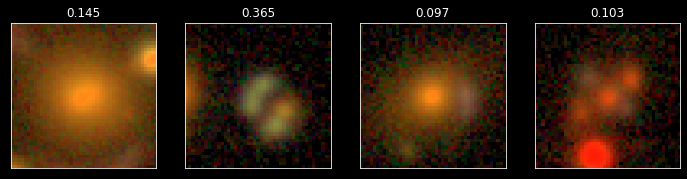

1311859703
1539815861
1328384049
1104152493


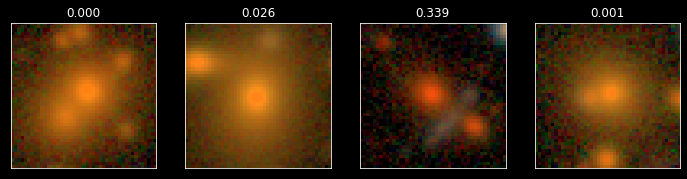

1339237461
1006400109
1370667532
1502820514


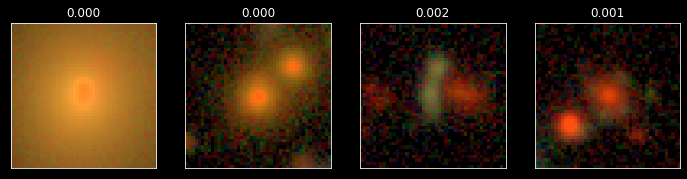

1286831512
1339976592
1227352718
1408480079


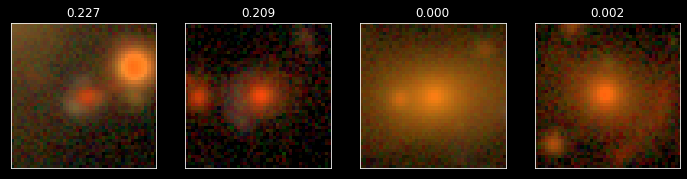

In [15]:
print('Wrong lenses')
print(len(wrong_positives))
print(len(wrong_data))
make_plot_all(wrong_positives, wrong_data)

Right lenses
1438681779
1293464062
945275549
1430614124


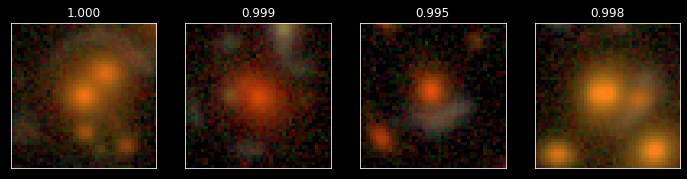

1170448654
1147402803
1610414328
1209117221


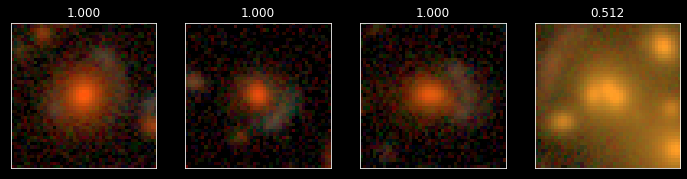

1491366260
1469887588
1472301145
1114679464


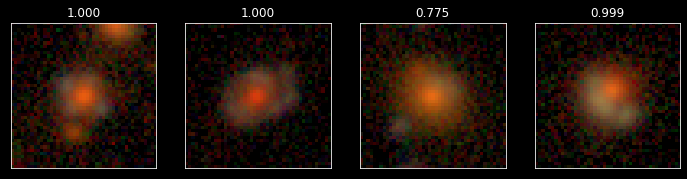

1204327104
995519978
1083587736
1567398970


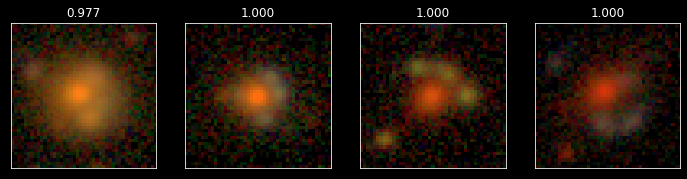

1301081250
1318291819
910349095
1301570222


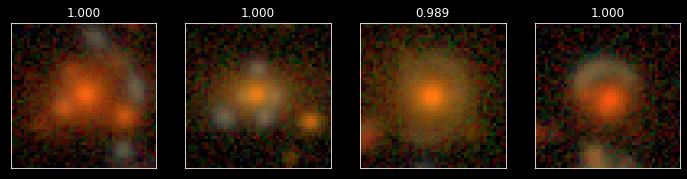

931521165
1238557756
1418898896
1148039203


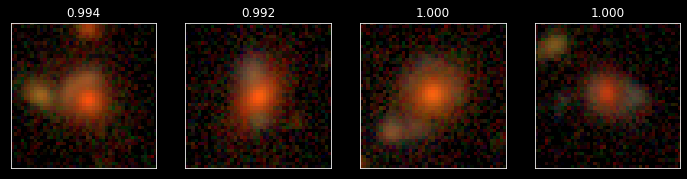

955546194
910130782
1069698905
1463283017


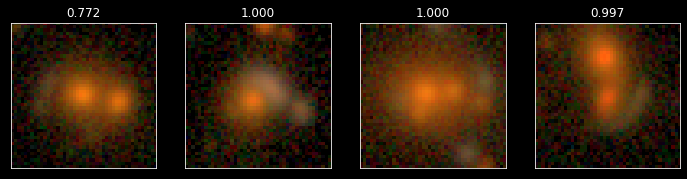

1539517051
1447194025
1577636680
1135365822


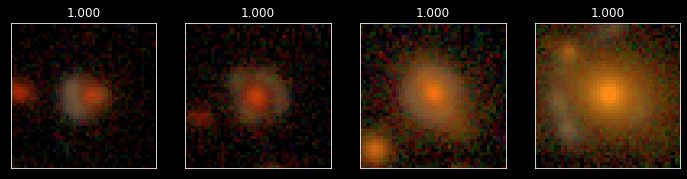

1377288600
1171046571
920001642
1136960821


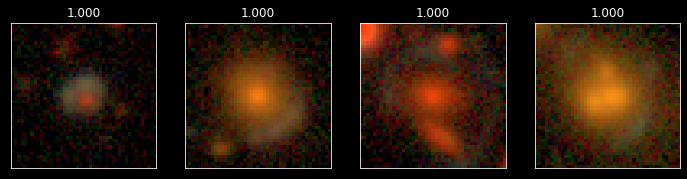

1322959708
1341869055
1616630786
997111564


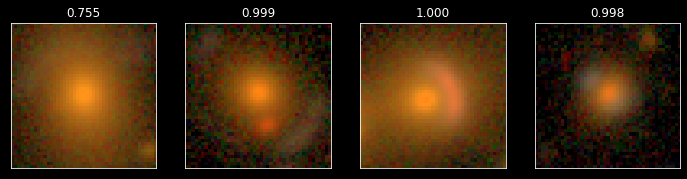

1317179527
1522557536
1269916975
1159257785


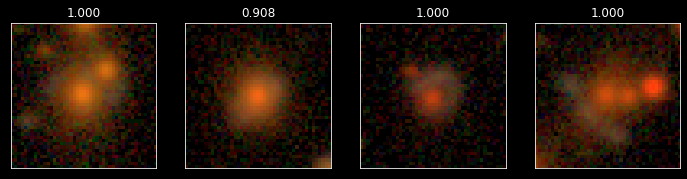

1616781749
1594751764
1404582289
1088494058


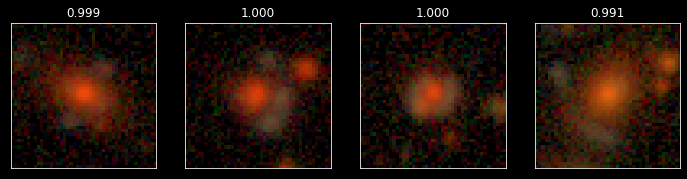

1225062343
1530676282
1397902720
1237543091


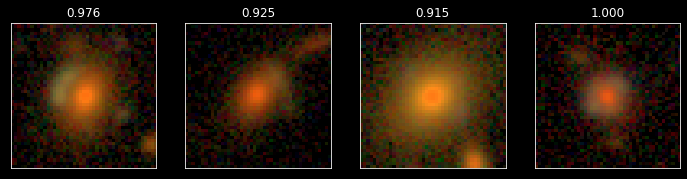

1497925832
1588291406
1150981093
1498870663


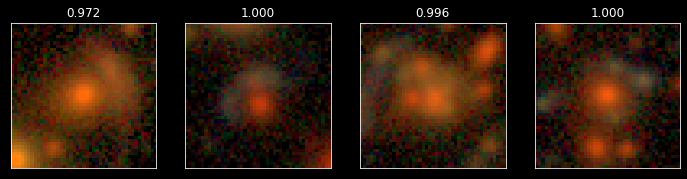

1620013669
1461036110
977402902
929174879


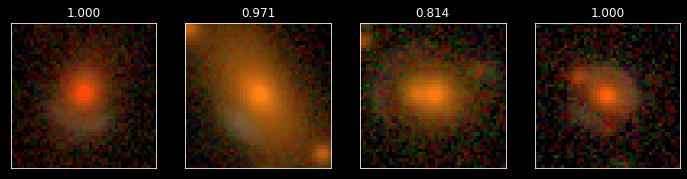

913936319
1183753773
1015396778
1386311701


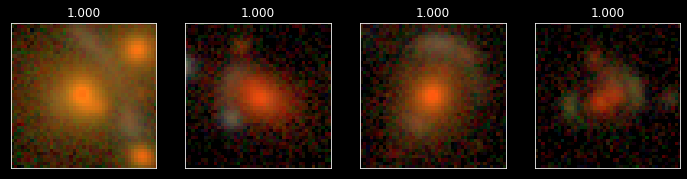

1254690304
1437028794
1429497103
1302925237


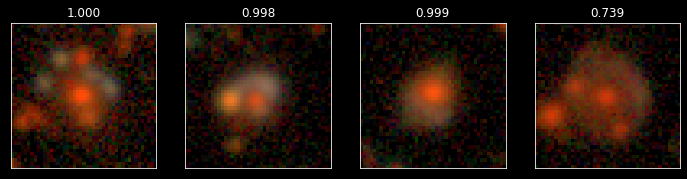

1597714254
1171125930
1382310111
1302396180


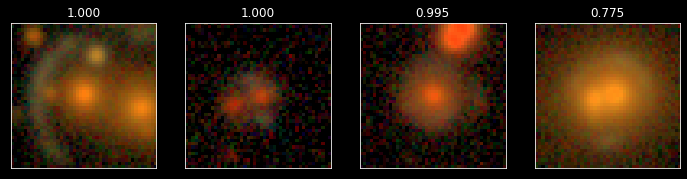

1032630238
1129249726
1449725103
1133082429


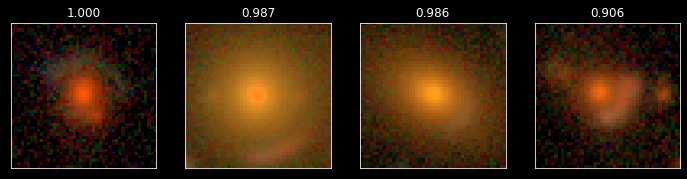

1190538563
1200974180
954133472
1136639478


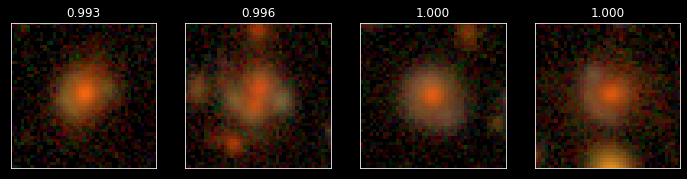

1585510883
1050596698
1403872468
1526026297


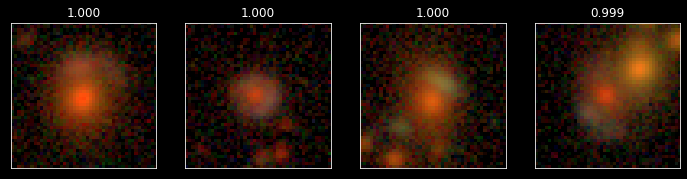

962781218
1261395335
1315004041
1588446577


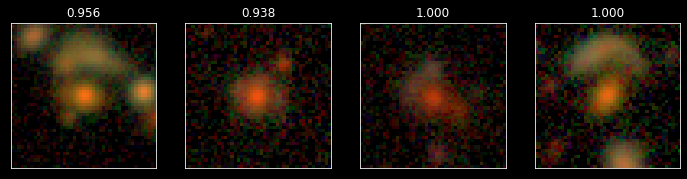

1482528707
1360486909
1088115093
1283494898


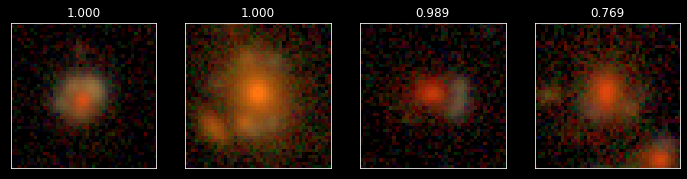

1196484135
1297510452
1202728609
1117638986


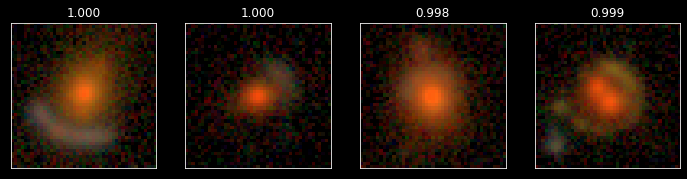

896927669
1536678003
1535198201
1360738327


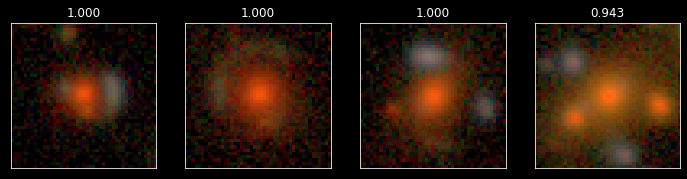

1203869644
1232668187
1240557273
1413196615


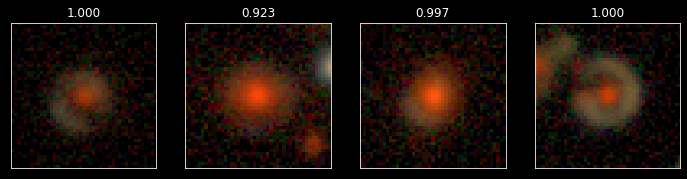

1369578668
1297126196
1360521121
1479275746


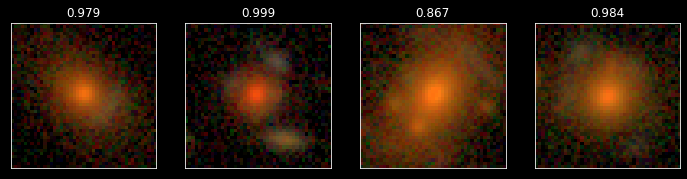

1364192755
1065852196
1431464188
1414539080


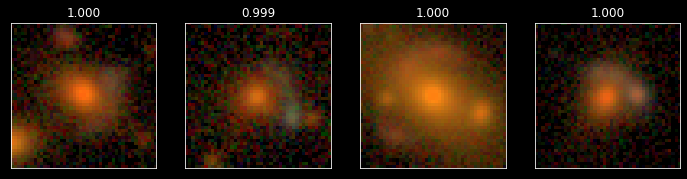

973022479
1070329410
1286124138
1591517201


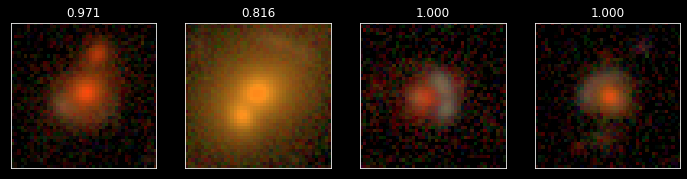

1225134030
1375955789
1301526898
909363984


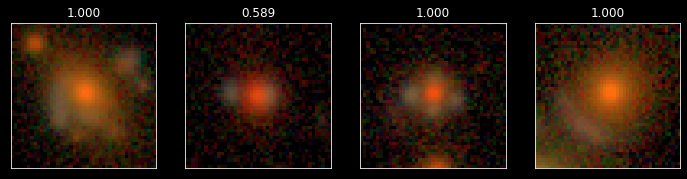

1332137965
1434471332
1287471303
947096663


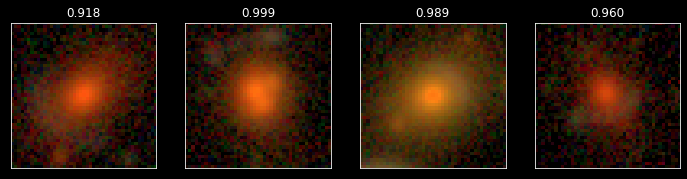

1211978531
1381955752
1452918181
1400483784


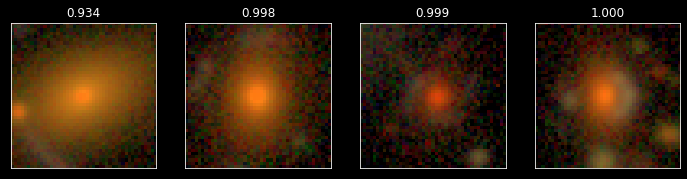

1445651907
1532546424
1615848001
1559829914


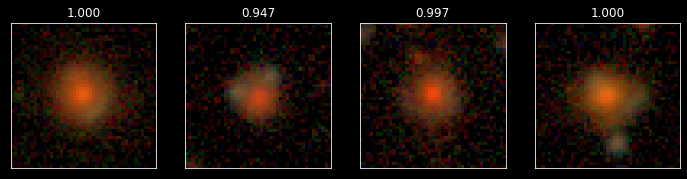

1612075297
1172896430
1419269561
1241426939


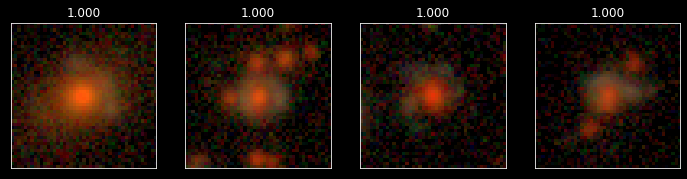

1520310906
1326909497
1386748971
1503701111


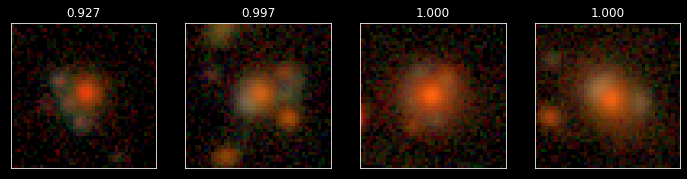

1355312134
922906010
1555731785
1194195904


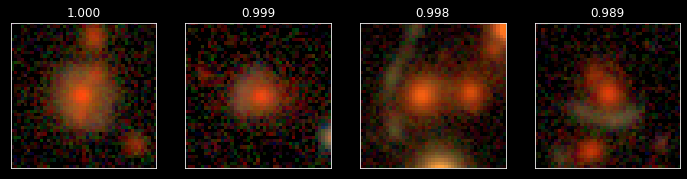

1144824191
1056483458
1305035224
873987650


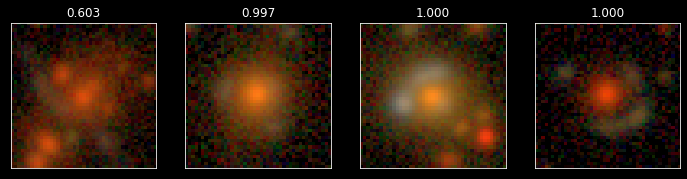

1142012795
1346717256
1042565305
976812438


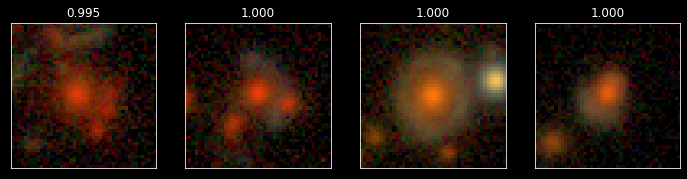

1417024449
1178164184
1302842192
1262961390


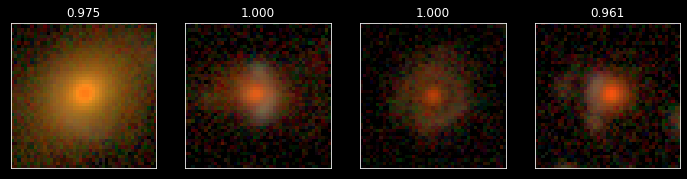

921061740
1517936143
1382509325
1201264241


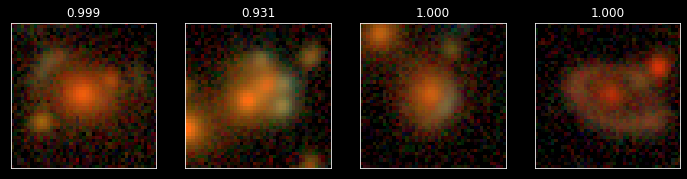

1032516085
1363280855
1610019605
1331280148


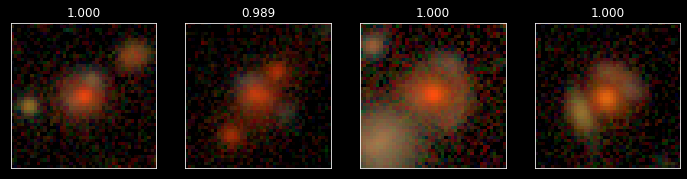

984685369
1154333895
1453824963
1358779892


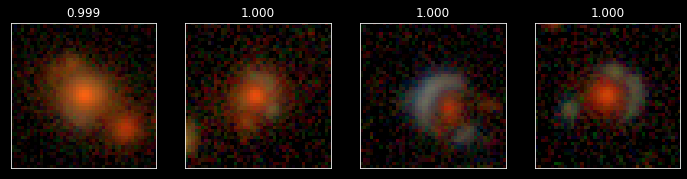

1526034878
1171524130
906297047
1237527717


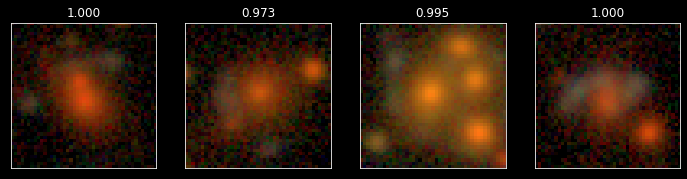

958711616
1126356733
1128123081
1195735459


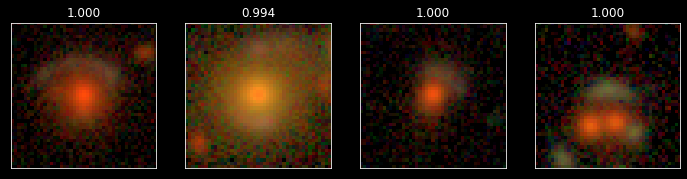

1193586965
895879313
1015482810
1379198488


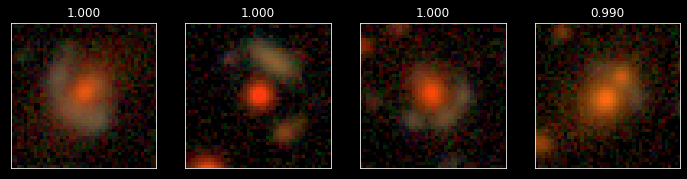

1243545869
902264453
1060824131
918607334


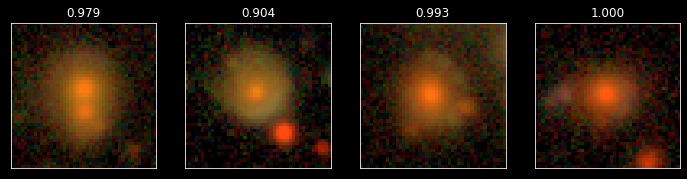

1222204219
1202909092
1342755111
1163516688


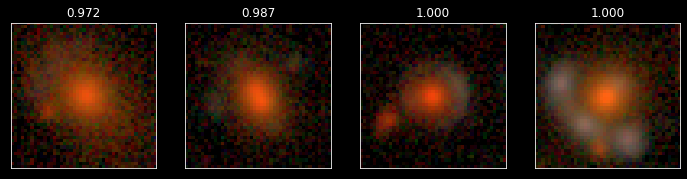

1545295456
1146656000
914485495
1173896612


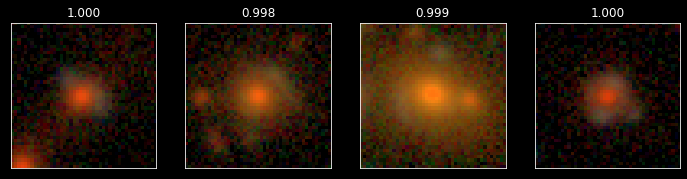

994248020
1067328323
1230981106
1226327844


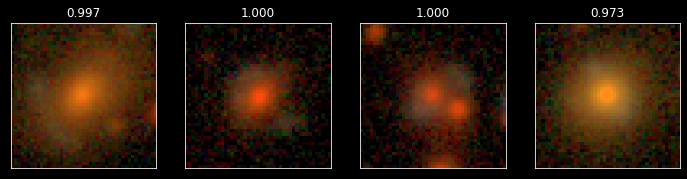

1006191814
1302030248
1234418937
1520163934


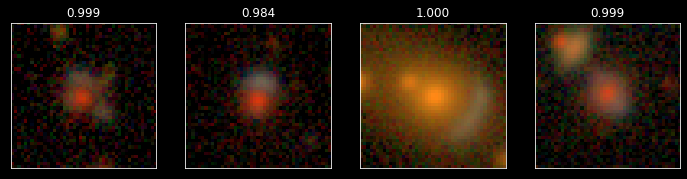

1325130567
1337371338
1366134685
984668871


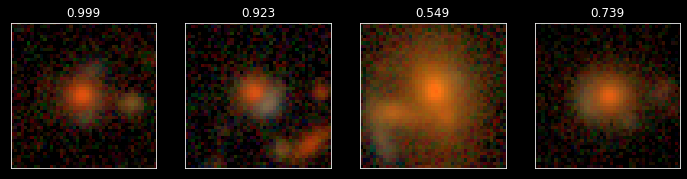

1055293331
1510652342
981794120
1104760496


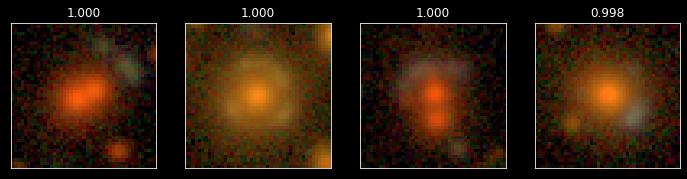

963722618
1396857779
957011358
1099283659


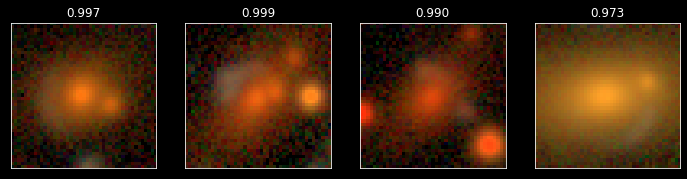

1375013657
1046854003
1441805121
1340791460


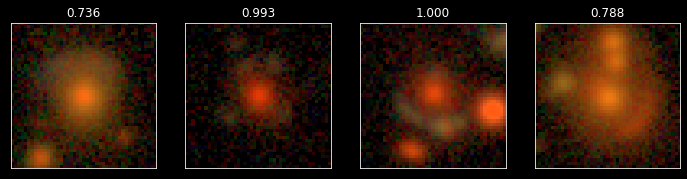

1469110768
1425763095
969674177
1605209704


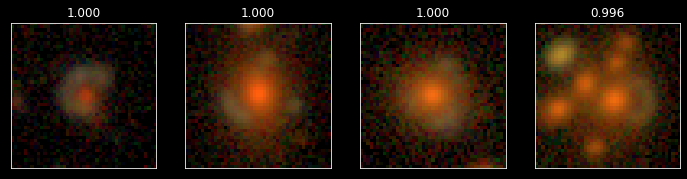

1275177571
1177839322
1380201297
1532731342


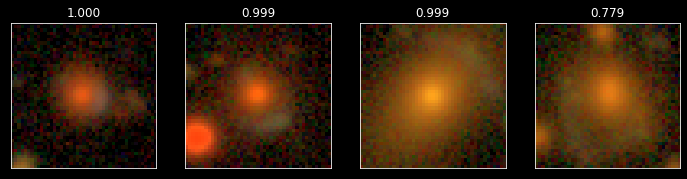

1196984339
936145598
1513432178
1014709737


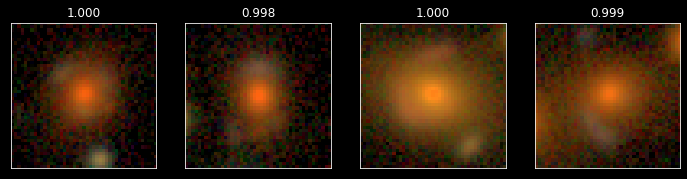

1235910677
1444457615
1483061451
1389731679


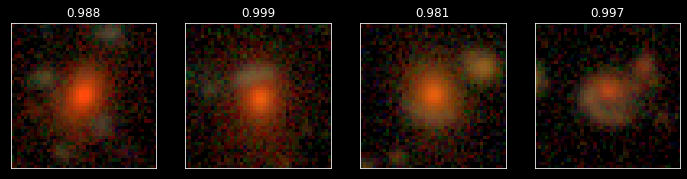

1521719117
1512709228
895557736
1231933469


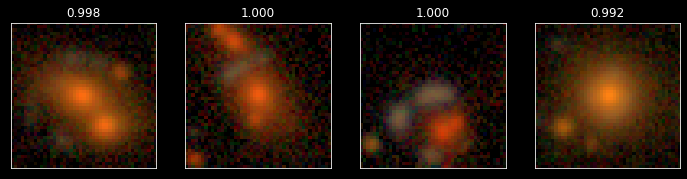

1423965682
1007321586
1522422819
1042572859


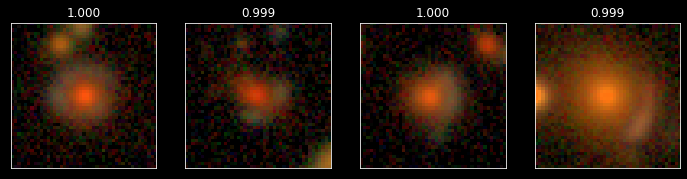

1222328257
1518164112
1170335487
916018816


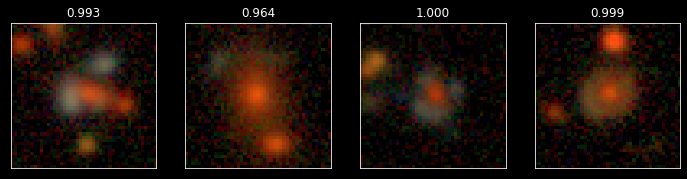

1088125980
906848959
920111245
1415379423


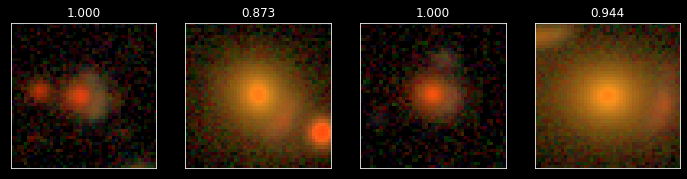

926358975
1128511911
1017262705
1383664897


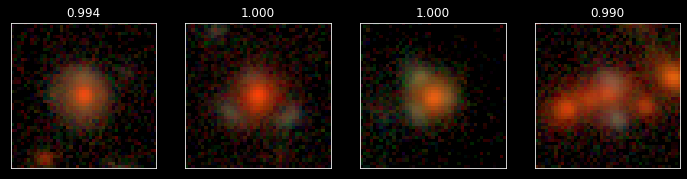

1569046306
1579060716
1466200592
937223786


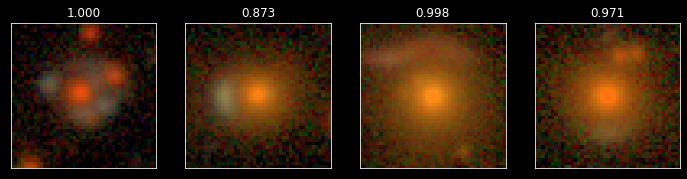

1326680132
1462363756
1395103367
1179738251


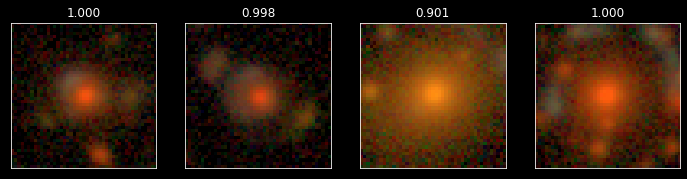

928276016
1493630017
1544277856
1477822151


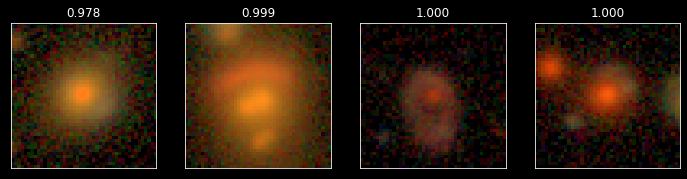

1104763422
1027020579
1218432734
1370850549


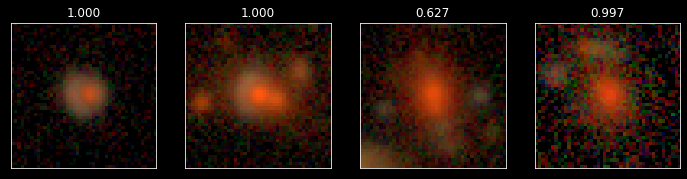

1229530106
1621540995
879403239
1093259184


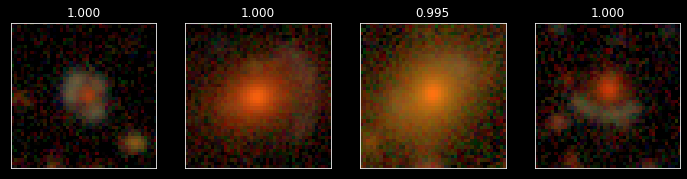

1022086875
1417914260
1058744217
1444903123


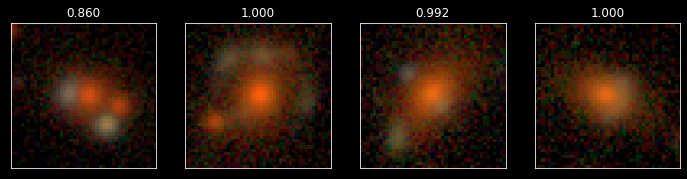

1363860461
939977129
1208164784
1445672622


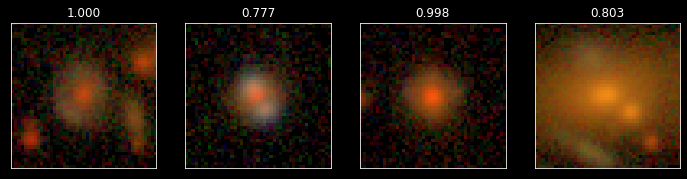

1243683190
1466401262
962178024
1337591104


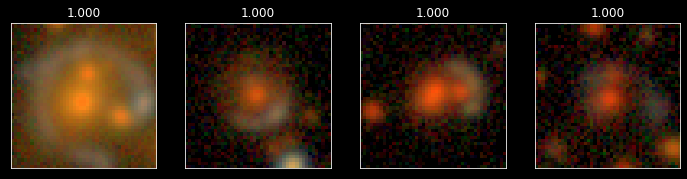

1164169304
996246835
1031154124
1610316947


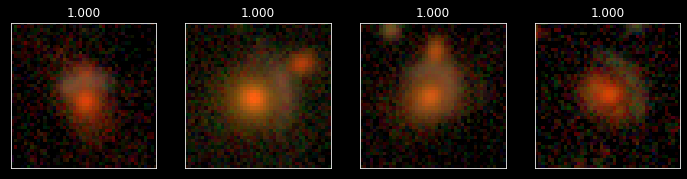

1051495539
1039481727
1446654681
1398238029


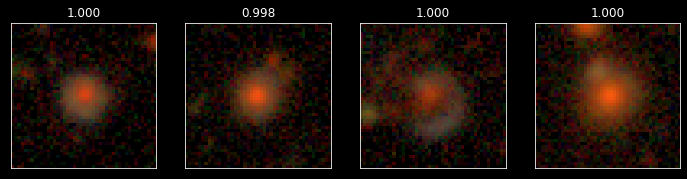

1390913339
1429276227
1410370257
1335651593


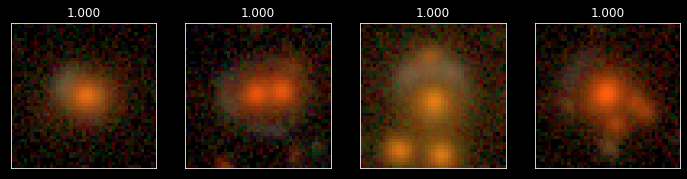

1224505431
1505900316
1353224538
1321063152


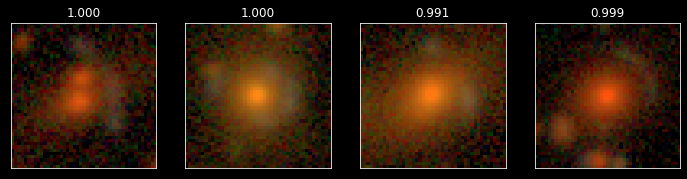

1529405528
1484242359
1027961497
1417265726


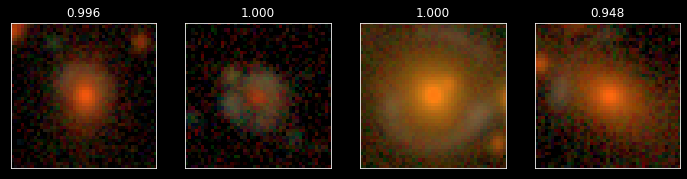

1385113597
1483219056
1235391858
914331956


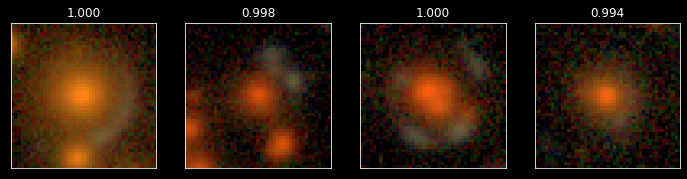

982753969
1414531628
1448527037
1074454732


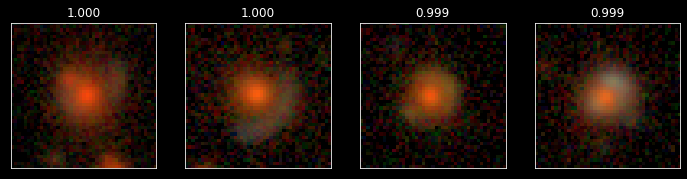

1329554469
1495778858
1406976127
1428022657


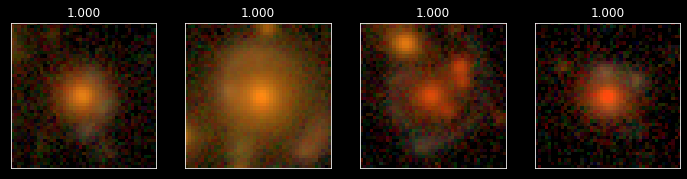

1621099134
1397786541
957012430
1153726289


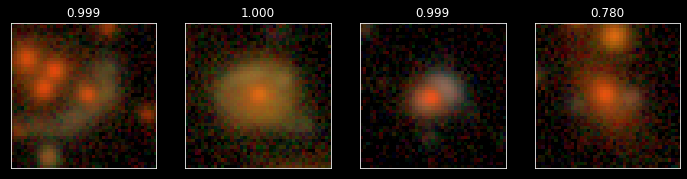

1048865468
1187097045
1343418575
1530473645


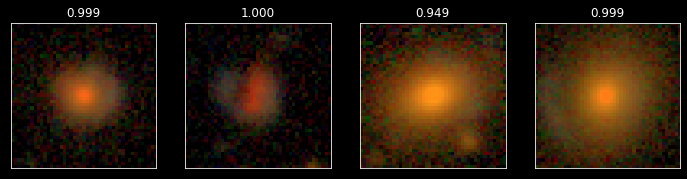

1368303750
1370519642
1367533692
1255097893


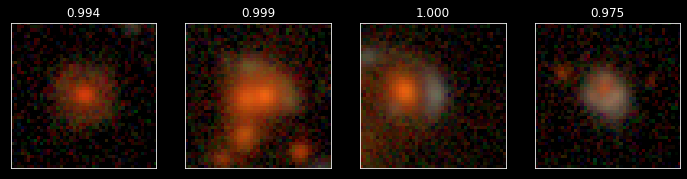

1470342587
1461199109
1399999613
1358003440


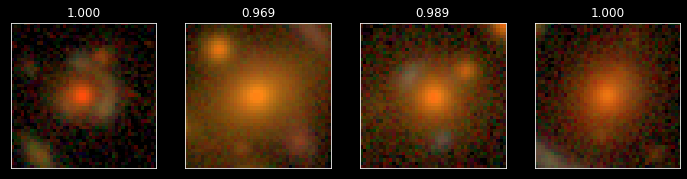

1296200194
1005730815
1519335321
1011752156


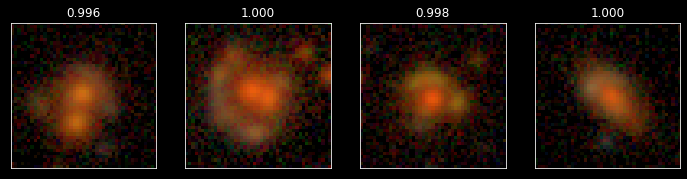

1077357392
1189746645
1198903075
1032572319


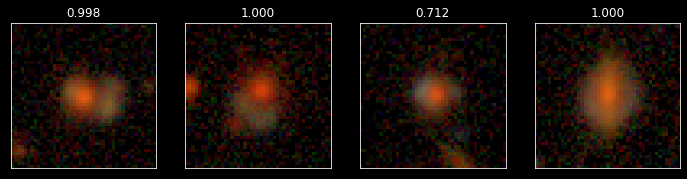

1214520967
1554912970
1558511112
884176328


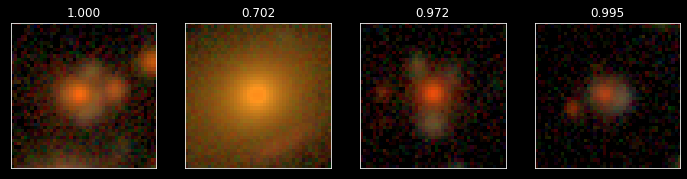

1162332513
1572658729
1561967167
1567663479


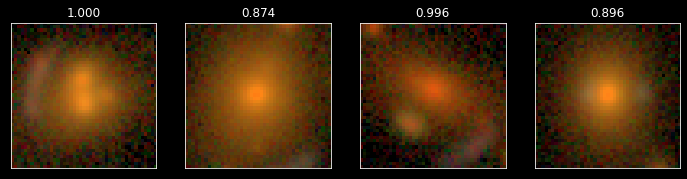

1313916462
1272147895
1534084624
1048920254


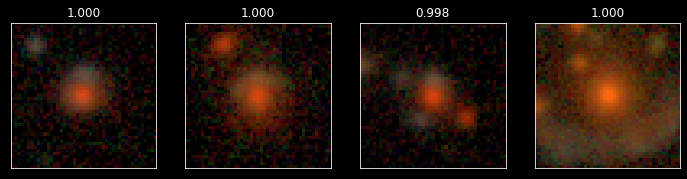

1129303315
1122461366
945447192
1054556683


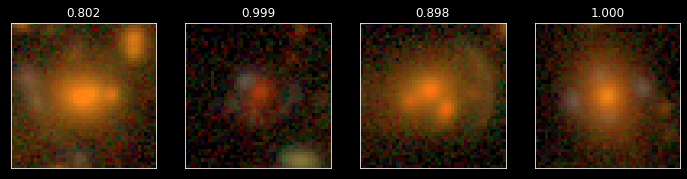

1172614654
1178407449
1324927887
1267465843


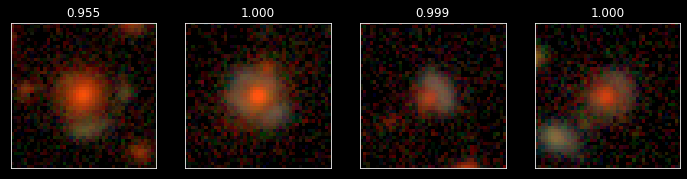

1367145325
1011953407
1097966135
1287909989


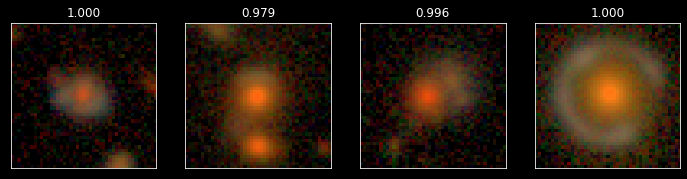

1613625064
1153333586
884307116
1253420372


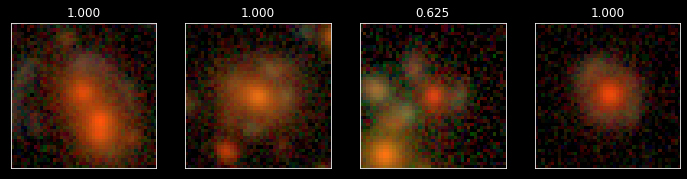

1314224614
1080776069
1499393985
1418184071


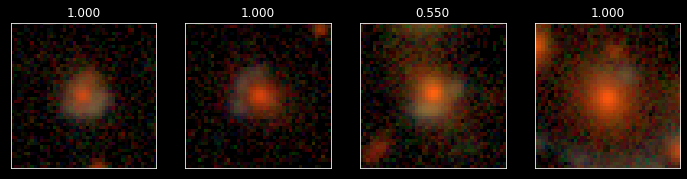

1425127607
1529154996
1136340852
1535218994


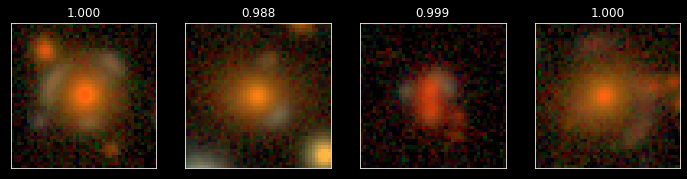

1307017630
1336392414
906132378
1449752819


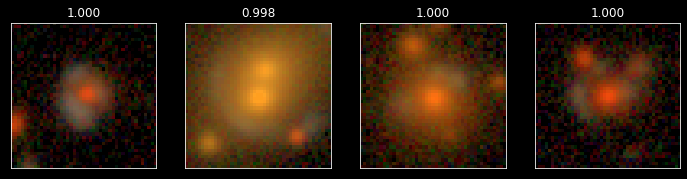

1289249195
1151529929
1429256248
1323083558


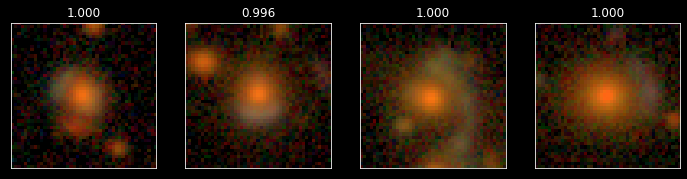

1377305692
1471530329
1015716039
1097396471


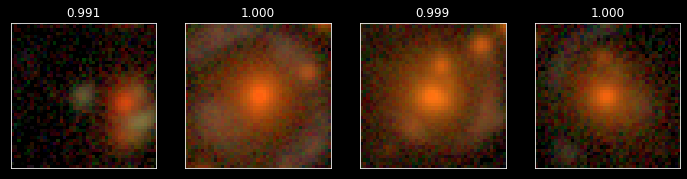

916084062
1451845442
1371478188
1194748640


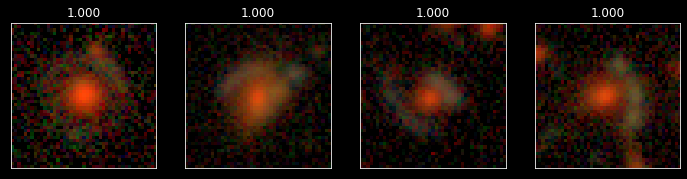

1437352224
1325770979
1309246601
1210605194


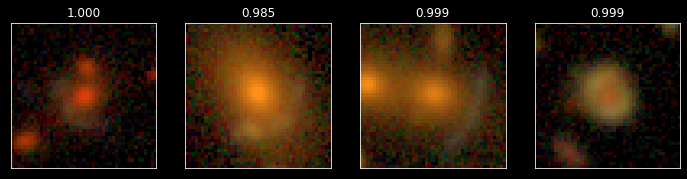

1502889148
1394738694
1114488763
1334070236


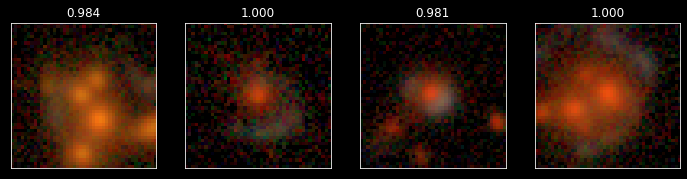

1277348353
1190063171
1335051094
1369699810


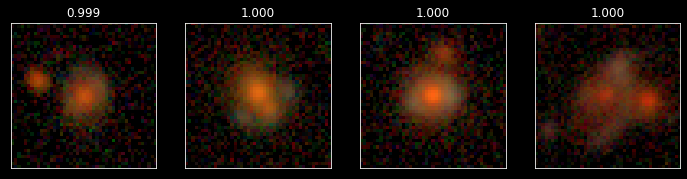

1458095582
1507428529
1482935849
1343800193


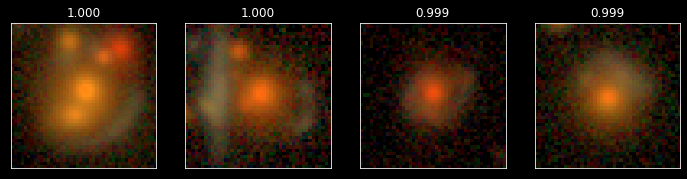

1121107640
1079352949
1463632393
1034878415


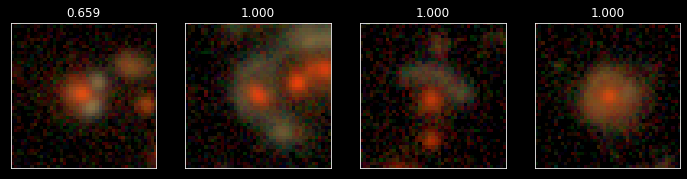

1133966811
1356429510
1186271916
924174668


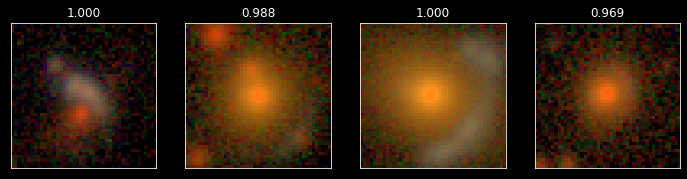

1302104402
1537991730
1452635200
1300215437


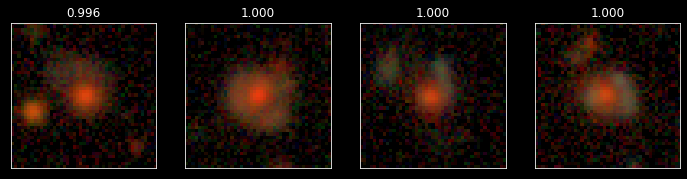

885335814
1249230135
1568765304
1493707761


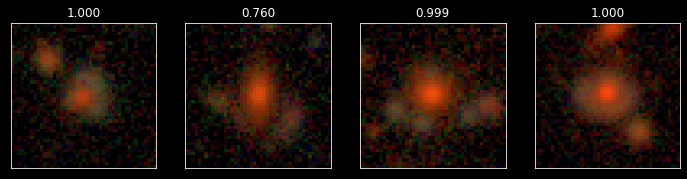

In [16]:
print('Right lenses')
make_plot_all(right_positives, right_data)

In [17]:
names = ['Prob', 'grade', 'photoz', 'imag', 'DNF_ZMEAN_SOF', 'FLUX_RADIUS_G', 'KRON_RADIUS', 'GAP_FLUX_G',
       'MAG_AUTO_G', 'MAG_APER_4_G', 'MAG_APER_8_G']

right_data = right_data[right_data['imag'] < 50]
wrong_data = wrong_data[wrong_data['imag'] < 50]

In [18]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    data_all = np.concatenate((right_data[name], wrong_data[name]))
    plt.hist(data_all, density = True, bins = 'auto', edgecolor = 'black')
    
    
    plt.subplot(1,2,2)
    plt.title(name)
    plt.hist(right_data[name], density = True, bins = 'auto', color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
    plt.hist(wrong_data[name], density = True, bins = 'auto', color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
    plt.legend()
    
    plt.show()
        

def make_all_histos():
    for name in names:
        make_histo(name)

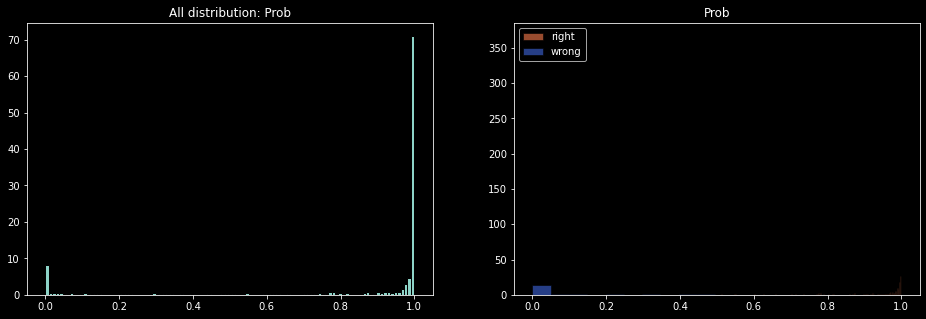

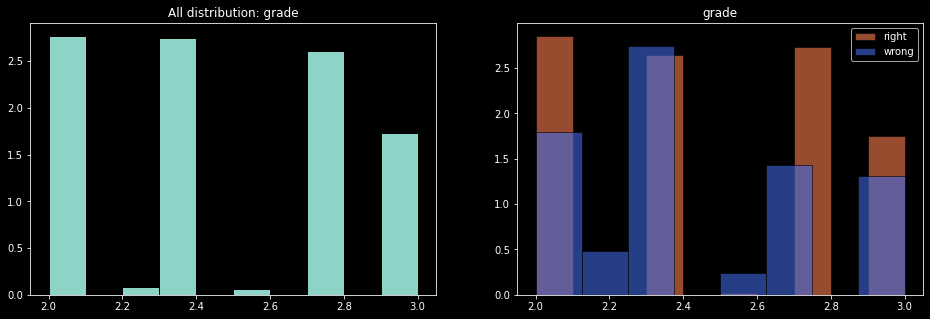

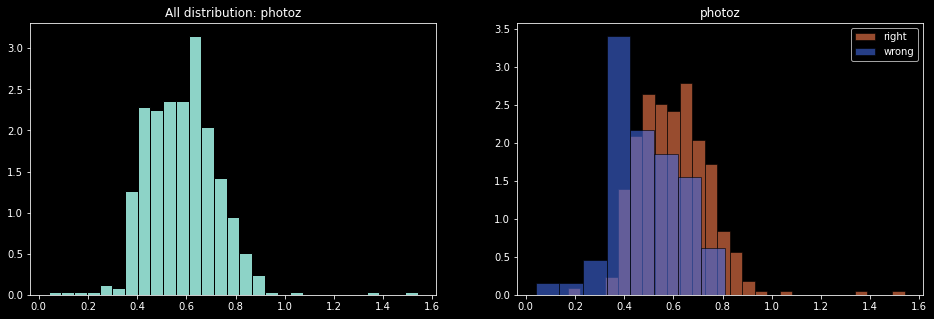

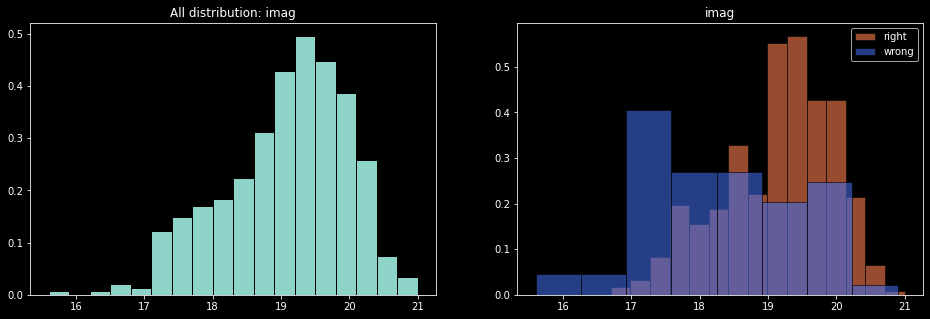

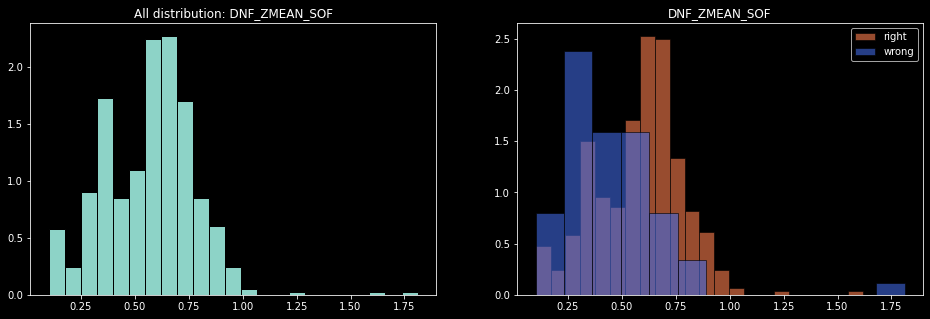

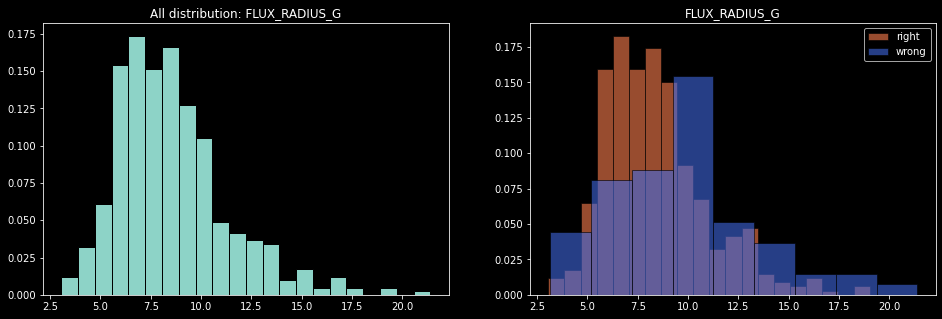

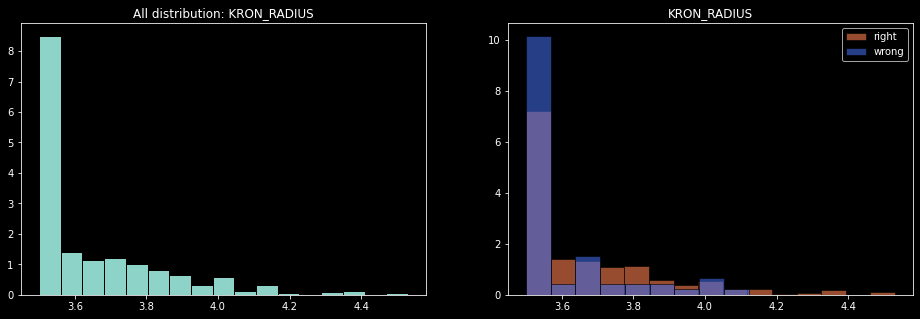

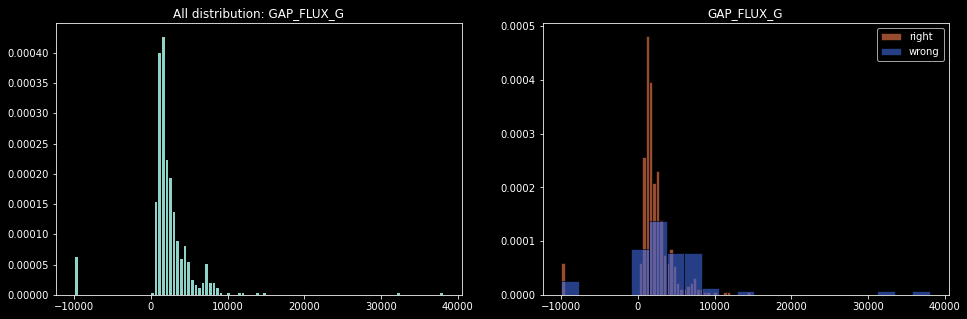

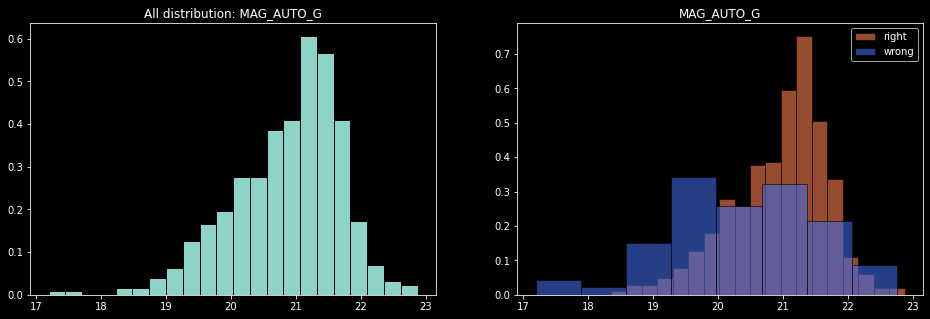

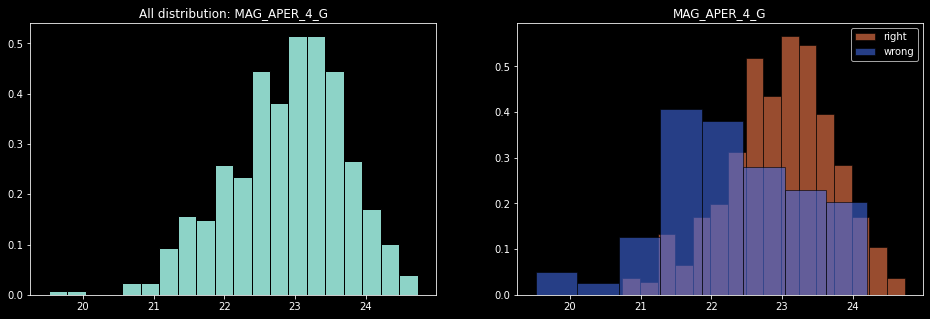

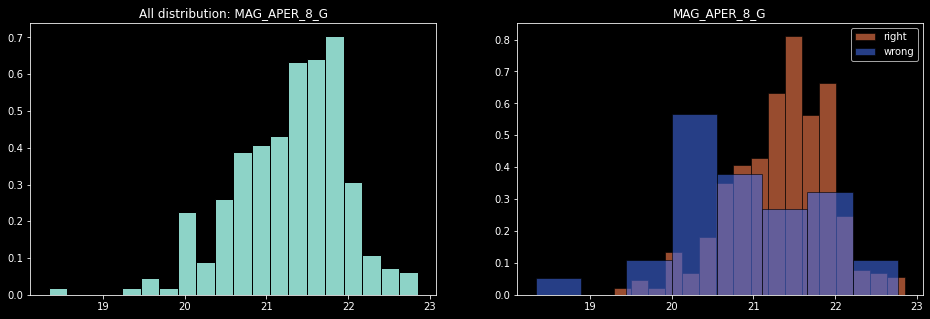

In [19]:
make_all_histos()

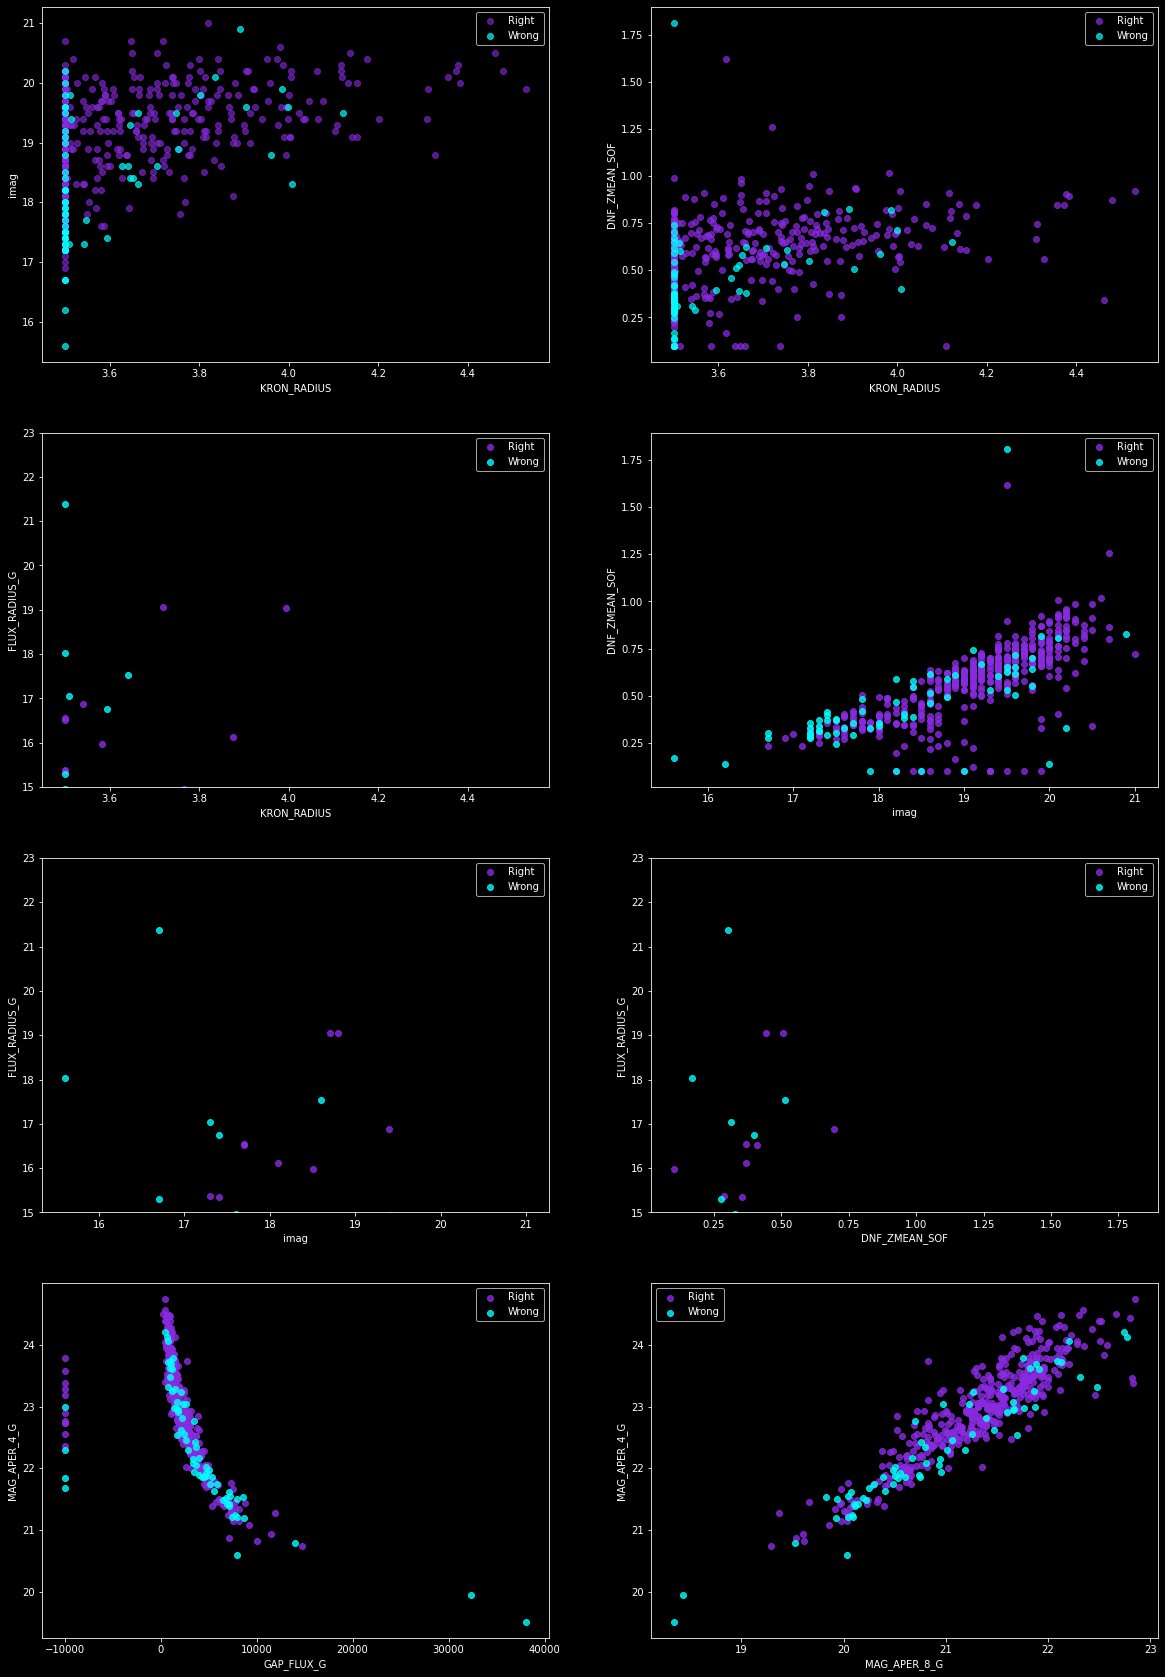

In [20]:
plt.figure(figsize=(20,30)) 

plt.subplot(4,2,1)
plt.xlabel(names[6])
plt.ylabel(names[3])
plt.scatter(right_data[names[6]], right_data[names[3]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(wrong_data[names[6]], wrong_data[names[3]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(4,2,2)
plt.xlabel(names[6])
plt.ylabel(names[4])
plt.scatter(right_data[names[6]], right_data[names[4]], color = 'blueviolet', alpha = 0.7, label ='Right')
plt.scatter(wrong_data[names[6]], wrong_data[names[4]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(4,2,3)
plt.xlabel(names[6])
plt.ylabel(names[5])
plt.ylim(15, 23)
plt.scatter(right_data[names[6]], right_data[names[5]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[6]], wrong_data[names[5]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(4,2,4)
plt.xlabel(names[3])
plt.ylabel(names[4])
plt.scatter(right_data[names[3]], right_data[names[4]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[3]], wrong_data[names[4]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(4,2,5)
plt.xlabel(names[3])
plt.ylabel(names[5])
plt.ylim(15, 23)
plt.scatter(right_data[names[3]], right_data[names[5]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[3]], wrong_data[names[5]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(4,2,6)
plt.xlabel(names[4])
plt.ylabel(names[5])
plt.ylim(15, 23)
plt.scatter(right_data[names[4]], right_data[names[5]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[4]], wrong_data[names[5]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 
    
plt.subplot(4,2,7)
plt.xlabel(names[7])
plt.ylabel(names[9])
#plt.ylim(15, 23)
plt.scatter(right_data[names[7]], right_data[names[9]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[7]], wrong_data[names[9]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend()     

plt.subplot(4,2,8)
plt.xlabel(names[10])
plt.ylabel(names[9])
#plt.ylim(15, 23)
plt.scatter(right_data[names[10]], right_data[names[9]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[10]], wrong_data[names[9]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend()   

plt.show()